## Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Bulk Volume Classification 
In the previous unit, you learnt to calculate the order flow of time bars and volume bars using the bulk volume classification (BVC) method. In this notebook, you will learn to implement the same in python. <br>
* In the case of time bars, the BVC method uses the change in 'price per unit volume' to calculate the order flow. The 'price per unit volume' is used to capture the volume information in time bars. <br>
* On the other hand, in the case of volume bars, the BVC method uses the price change to calculate the order flow. Just the price change was used since the volume bars already capture the information from the volume.

In this notebook, you will implement the BVC method to calculate the order flow for the time bars and volume bars in python. 

The notebook is structured as follows:
1. [Read the Time Bars Data](#timebarsdata)
1. [Calculate Order Flow: Time Bars](#orderflowtimebars)
1. [Plot the Order Flow: Time Bars](#plottimebars)
1. [Calculate Order Flow: Volume Bars](#calculateorderflowvolumebars)
1. [Plot the Order Flow: Volume Bars](#plotvolumebars)
1. [Conclusion and Next Steps](#conclusion)




## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
from scipy.stats import norm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<a id='timebarsdata'></a>
## Read the Time Bars Data
Import the csv `time_bars_es500_2013_10_02_100_milliseconds.csv` as the dataframe `time_bars`. This CSV was created in the notebook of the previous section with the unit name - 'Calculate Time and Volume Bars'. This csv file has 100 millisecond time bars of E-mini S&P 500 futures for the date `2013-10-02`. This dataset has columns `open`, `high`, `low`, `close` and `volume`. This csv file is available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section. 

In [2]:
# Read the 'time_bars_es500_2013_10_02' csv file as 'time_bars' dataframe
time_bars = pd.read_csv('../data_modules/time_bars_es500_2013_10_02_100_milliseconds.csv', index_col=0)

# Print the data of first five time bars
time_bars.head()

,open,high,low,close,volume
2013-10-02 00:00:00.600,1428.75,1428.75,1428.75,1428.75,1.0
2013-10-02 00:00:10.900,1428.75,1428.75,1428.75,1428.75,25.0
2013-10-02 00:00:19.400,1429.00,1429.00,1429.00,1429.00,28.0
2013-10-02 00:00:19.500,1429.00,1429.00,1429.00,1429.00,28.0
2013-10-02 00:00:19.600,1429.00,1429.00,1429.00,1429.00,3.0


<a id='orderflowtimebars'></a>
## Calculate Order Flow: Time Bars

According to the bulk volume classification, the order flow is the difference between buy volume and sell volume.<br>
The BVC method uses the change in 'price per unit volume' to calculate order flow using the time bars. 

![BVC_Time_Bars.jpg](https://d2a032ejo53cab.cloudfront.net/Glossary/Fa6qnFwv/Untitled-Diagram-Page-1.drawio.png) <br>


#### Steps to calculate the order flow using BVC method for time bars

**Step-1:** Price per unit volume<br>
**Step-2:** Price change<br>
**Step-3:** Standard deviation of price change<br>
**Step-4:** Buy volume<br>
**Step-5:** Sell volume<br>
**Step-6:** Order flow <br>

### Price per Unit Volume
**Step-1:** Price per Unit Volume<br><br>
The price per unit volume is calculated by dividing the `close` with `volume`.

In [3]:
# Calculate price per unit volume
time_bars['price_per_unit_volume'] = time_bars.close/time_bars.volume

### Price Change
**Step-2:** Price Change <br><br>
To calculate the the price change, use the `diff()` method on `price_per_unit_volume`.

In [4]:
# Calculate change in price per unit volume
time_bars['price_change'] = time_bars.price_per_unit_volume.diff()

### Standard Deviation of price change
**Step-3:** Standard deviation of price change<br>

* Calculate the  standard deviation of the price change for each row by using the data till the current row in the `time_bars` dataframe. <br>
* The `expanding()` method is used to create a rolling window that starts from the first row of the dataframe and expands with each subsequent row.<br>
* The `std()` method is then applied to this expanding window to calculate the standard deviation of the price change values within the window. The resulting standard deviation value is then assigned to the `std` column in the `time_bars` dataframe. 


In [5]:
# Calculate standard deviation of change in price per unit volume
time_bars['std'] = time_bars['price_change'].expanding().std()

### Buy Volume
**Step-4:** Buy volume<br><br>
The following equation is used to calculate the buy volume.<br> 

**Buy Volume ($V_{B}$) :** 
<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/WMG0hHUr/buy-volume.png" width="400"><br>

* In the above equation P(t) and P(t-1) represent the close prices of the current time bar and previous time bars. <br>
* V(t) is the volume of the current time bar and Z represents the cumulative Gaussian distribution function. <br>

The `norm()` module from the `scipy.stats` library is used to calculate the cumulative distribution function of a Gaussian distribution. `norm.cdf(x)` outputs the cumulative distribution function of a gaussian distribution at x.

In [6]:
# Calculate the buy volume and store it in the column 'buy_volume' in the dataframe 'time_bars'
time_bars['buy_volume'] = time_bars['volume'] * \
    ((time_bars['price_change']/time_bars['std'])
     .apply(lambda x: norm.cdf(x)))

**Step-5:** Sell volume<br><br>
The sell volume is calculated by subtracting the buy volume from the total volume. <br><br>
**Sell Volume ($V_{S}$) :** 
<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/AUjuhqYv/sell-volume.png" width="250"><br>

In [7]:
# Calculate the sell volume and store it in the column 'sell_volume' in the dataframe 'time_bars'
time_bars['sell_volume'] = time_bars['volume']-time_bars['buy_volume']

 **Step-6:** Order flow<br>
 
 As per the bulk volume classification method, the order flow is the difference between the buy volume and sell volume.<br><br>
**Order Flow :** 

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/ND2zWxjw/orderflow.png" width="300"><br>

In [8]:
# Calculate the order flow and store it in the column 'order_flow' of the dataframe 'time_bars'
time_bars['order_flow'] = time_bars['buy_volume']-time_bars['sell_volume']

# Select columns for the order flow dataframe and drop rows with any missing data
time_bars = time_bars[['buy_volume', 'sell_volume', 'order_flow']]
time_bars = time_bars.dropna()

### BVC order flow function
The following is the function named `bvc` which takes time bars as input and returns a dataframe with columns `buy_volume`, `sell_volume`, `order_flow`.

In [9]:
def bvc(data):
    # Calculate price per unit volume
    data['price_per_unit_volume'] = data['close']/data['volume']

    # Calculate change in price per unit volume
    data['price_change'] = data.price_per_unit_volume.diff()

    # Calculate standard deviation of change in price per unit volume
    data['std'] = data['price_change'].expanding().std()

    # Calculate the buy volume and store it in the column 'buy_volume' in the dataframe 'data'
    data['buy_volume'] = data['volume'] * \
        ((data['price_change']/data['std'])
         .apply(lambda x: norm.cdf(x)))

    # Calculate the sell volume and store it in the column 'sell_volume' in the dataframe 'data'
    data['sell_volume'] = data['volume']-data['buy_volume']

    # Calculate the order flow and store it in the column 'order_flow' of the dataframe 'data'
    data['order_flow'] = data['buy_volume']-data['sell_volume']

    # Select columns for the order flow dataframe and drop rows with any missing data
    data = data[['buy_volume', 'sell_volume', 'order_flow']]
    data = data.dropna()

    return data

In [10]:
# Calculate the order flow using the bvc function and store it in `time_bars`
time_bars = bvc(pd.read_csv('../data_modules/time_bars_es500_2013_10_02_100_milliseconds.csv', index_col=0))

# Print the last 5 rows of the dataframe `time_bars`
time_bars.tail()

,buy_volume,sell_volume,order_flow
2013-10-02 23:59:19.900,0.322077,2.677923,-2.355847
2013-10-02 23:59:24.600,1.753503,2.246497,-0.492993
2013-10-02 23:59:35.000,0.918562,0.081438,0.837123
2013-10-02 23:59:37.500,0.352267,1.647733,-1.295465
2013-10-02 23:59:55.000,1.000000,1.000000,0.000000


<a id='plottimebars'></a>
## Plot the Order Flow: Time Bars

Create a bar chart to visualise the order flow data for the last 100 time bars. The data is defined as the variable `plot_data` which is a slice of the original `time_bars` data. <br>
Plot the positive and negative order flow bars separately in green and red, respectively.

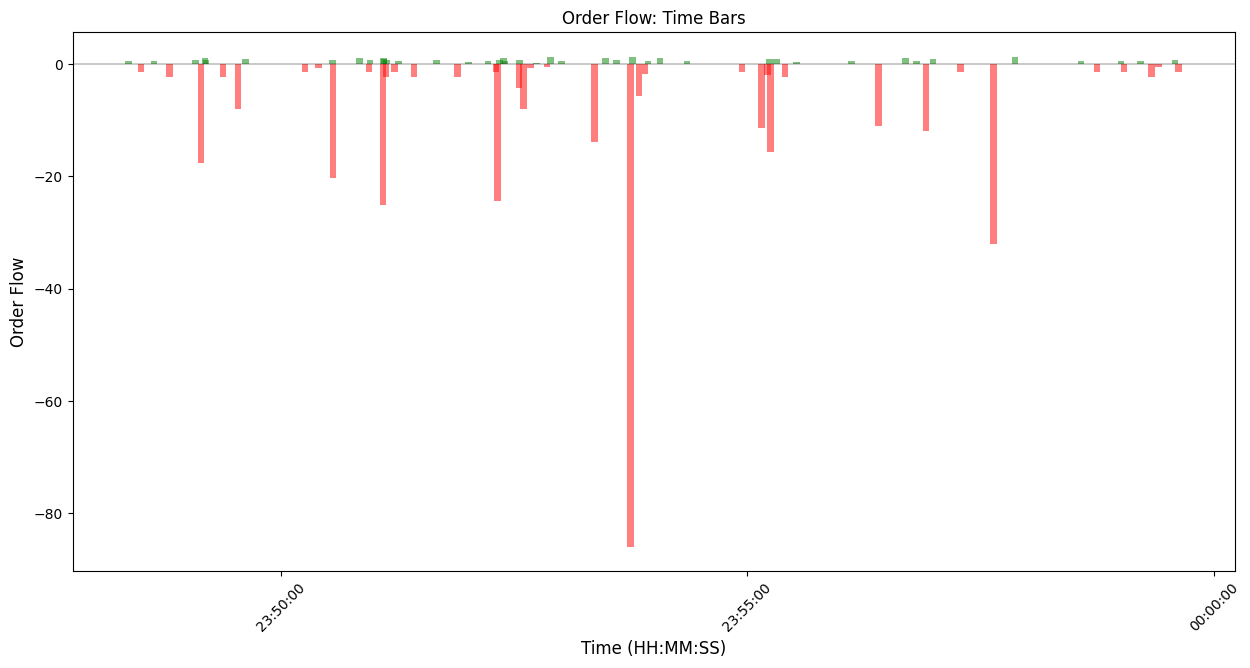

In [11]:
# Define the data to be plotted
plot_data = time_bars[-100:]

# Convert the index to datetime format
plot_data.index = pd.to_datetime(plot_data.index)

# Create a figure and subplot with a specific size
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the positive order flow bars
ax.bar(plot_data.index[plot_data['order_flow'] > 0],  plot_data['order_flow']
       [plot_data['order_flow'] > 0].values, color='g', alpha=0.5, width=0.00005)

# Plot the negative order flow bars
ax.bar(plot_data.index[plot_data['order_flow'] < 0],  plot_data['order_flow']
       [plot_data['order_flow'] < 0].values, color='r', alpha=0.5, width=0.00005)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linewidth=0.3)

# Set the title of the plot
ax.set_title('Order Flow: Time Bars')

# Set the x-axis label and font size
ax.set_xlabel('Time (HH:MM:SS)', fontsize=12)

# Format the x-axis labels to show hours, minutes, and seconds
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Set the y-axis label
ax.set_ylabel('Order Flow', fontsize=12)

# Rotate the x-axis tick labels by 45 degrees for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

<a id='calculateorderflowvolumebars'></a>
## Calculate Order Flow: Volume Bars
The BVC method uses the price change to calculate order flow using the volume bars.


## Read the Volume Bars Data
Import the CSV `volume_bars_es500_2013_10_02_100_milliseconds.csv` as the dataframe `volume_bars`. This CSV was created in the notebook of the previous section with the unit name - 'Calculate Time and Volume Bars'. This CSV file has volume bars with the volume threshold of 10000 E-mini S&P 500 futures for the date `2013-10-02`. This dataset has columns `start_time`, `end_time`, `open`, `high`, `low`, `close` and `volume`. This csv file is available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section. 

In [12]:
# Read the 'volume_bars_es500_2013_10_02' csv file as 'volume_bars' dataframe
volume_bars = pd.read_csv('../data_modules/volume_bars_es500_2013_10_02_100_milliseconds.csv', index_col=0)

# Print the data of first five volume bars
volume_bars.head()

,start_time,end_time,open,high,low,close,volume
2013-10-02 00:00:00.604800,2013-10-02 00:00:00.604800,2013-10-02 00:00:44.150400,1428.75,1429.0,1428.75,1429.00,102.0
2013-10-02 00:00:47.433600,2013-10-02 00:00:47.433600,2013-10-02 00:04:16.521599,1429.00,1429.0,1428.75,1429.00,158.0
2013-10-02 00:04:16.521599,2013-10-02 00:04:16.521599,2013-10-02 00:05:17.692800,1429.00,1429.0,1428.00,1428.00,104.0
2013-10-02 00:05:23.049600,2013-10-02 00:05:23.049600,2013-10-02 00:10:35.558400,1428.25,1429.0,1428.00,1428.25,101.0
2013-10-02 00:10:46.790400,2013-10-02 00:10:46.790400,2013-10-02 00:13:21.792000,1429.00,1429.0,1428.50,1429.00,166.0


![bvc_vol_bars.jpg](https://d2a032ejo53cab.cloudfront.net/Glossary/K9AO39Ol/Untitled-Diagram-Copy-of-Page-1.drawio.png) <br>

#### Steps to calculate the order flow using BVC method for volume bars

**Step-1:** Price change<br>
**Step-2:** Standard deviation of price change<br>
**Step-3:** Buy volume<br>
**Step-4:** Sell volume<br>
**Step-5:** Order flow <br>

Since each volume bar has almost the same volume which would be equal or greater than the threshold, the bvc function can also be used with volume bars as the input to calculate the order flow. 

In [13]:
# Calculate the order flow using the bvc function and store it in `volume_bars`
volume_bars = bvc(volume_bars)

# Print the first 5 rows of the dataframe `volume_bars`
volume_bars.head(5)

,buy_volume,sell_volume,order_flow
2013-10-02 00:04:16.521599,78.400706,25.599294,52.801412
2013-10-02 00:05:23.049600,53.914365,47.085635,6.828730
2013-10-02 00:10:46.790400,20.949942,145.050058,-124.100117
2013-10-02 00:13:21.878400,89.311002,53.688998,35.622005
2013-10-02 00:16:15.369600,80.784381,42.215619,38.568762


<a id='plotvolumebars'></a>
## Plot the Order Flow of Volume Bars

Create a bar chart to visualise the order flow data for the first 20 volume bars. The data is defined as the variable `plot_data` which is a slice of the original `volume_bars` data. <br>
Plot the positive and negative order flow bars separately in green and red, respectively.

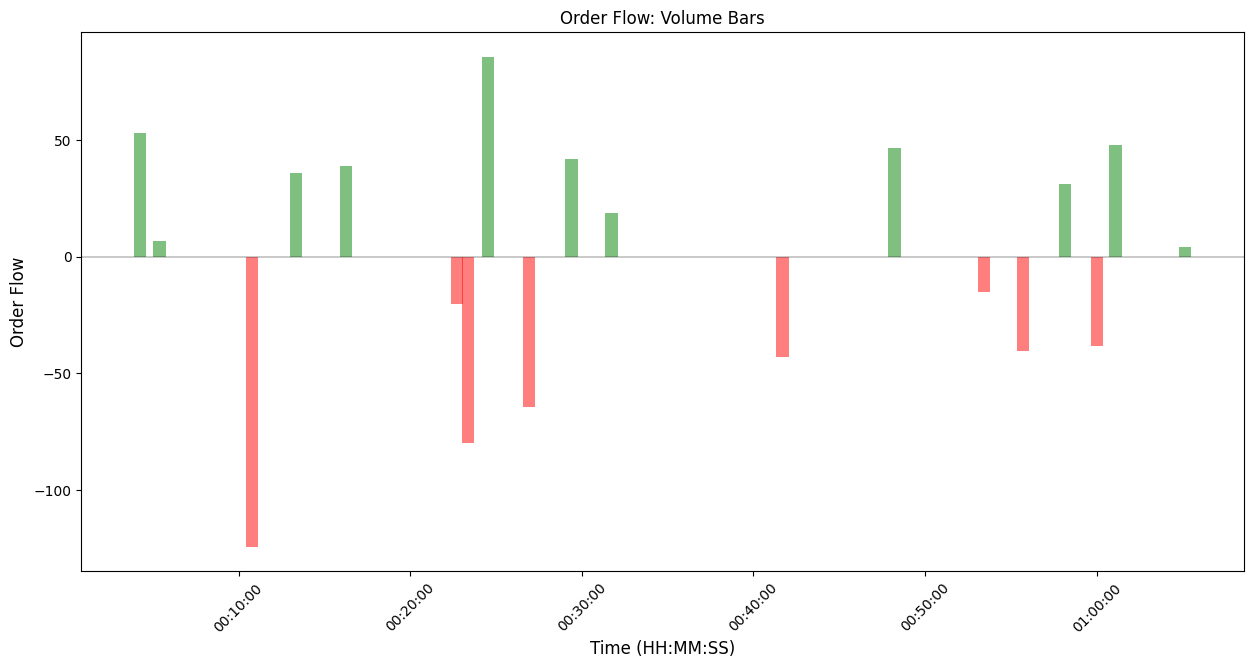

In [14]:
# Define the data to be plotted
plot_data = volume_bars[:20]

# Convert the index to datetime format
plot_data.index = pd.to_datetime(plot_data.index)

# Create a figure and subplot with a specific size
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the positive order flow bars
ax.bar(plot_data.index[plot_data['order_flow'] > 0],  plot_data['order_flow']
       [plot_data['order_flow'] > 0].values, color='g', alpha=0.5, width=0.0005)

# Plot the negative order flow bars
ax.bar(plot_data.index[plot_data['order_flow'] < 0],  plot_data['order_flow']
       [plot_data['order_flow'] < 0].values, color='r', alpha=0.5, width=0.0005)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linewidth=0.3)

# Set the title of the plot
ax.set_title('Order Flow: Volume Bars')

# Set the x-axis label and font size
ax.set_xlabel('Time (HH:MM:SS)', fontsize=12)

# Format the x-axis labels to show hours, minutes, and seconds
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Set the y-axis label
ax.set_ylabel('Order Flow', fontsize=12)

# Rotate the x-axis tick labels by 45 degrees for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

<a id='conclusion'></a>
## Conclusion and Next Steps

In this notebook, you learnt to calculate order flow for time bars and volume bars using the bulk volume classification method. It's recommended to use volume bar data to calculate order flow using the BVC method since volume bars provide a more direct measure of the level of trading activity in the market. <br>
You can also use alternative bars such as dollar-volume bars to calculate the order flow using the BVC method. <br>
In the upcoming units, you will learn to create and backtest a trading strategy based on the order flow. <br><br>